# Imports

In [46]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import numpy as np

### Read the dataframe

In [2]:
df_grape=pd.read_csv('../../data/GRAPE_QUALITY.csv')
df_grape.head()

,sample_id,variety,region,quality_score,quality_category,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,harvest_date,sun_exposure_hours,soil_moisture_percent,rainfall_mm
0,1,Riesling,Barossa Valley,2.11,Medium,13.70,3.17,251.81,18.58,2023-09-04,8.4,55.9,223.3
1,2,Pinot Noir,Loire Valley,2.83,High,20.84,3.15,289.00,22.08,2023-09-16,8.8,36.9,312.1
2,3,Sauvignon Blanc,Napa Valley,3.52,Premium,27.46,4.07,125.14,21.40,2023-08-25,11.1,64.9,698.7
3,4,Riesling,Napa Valley,2.28,Medium,24.64,3.15,237.46,12.31,2023-09-13,8.0,54.5,660.1
4,5,Merlot,Napa Valley,2.90,High,26.13,3.18,221.52,12.24,2023-08-11,11.2,36.3,410.4


In [3]:
df_grape.dtypes

sample_id                  int64
variety                   object
region                    object
quality_score            float64
quality_category          object
sugar_content_brix       float64
acidity_ph               float64
cluster_weight_g         float64
berry_size_mm            float64
harvest_date              object
sun_exposure_hours       float64
soil_moisture_percent    float64
rainfall_mm              float64
dtype: object

In [4]:
df_grape.set_index('sample_id', inplace=True)

In [5]:
df_grape.describe()

,quality_score,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,sun_exposure_hours,soil_moisture_percent,rainfall_mm
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,2.49436,20.140150,3.503410,197.112470,17.411620,8.992600,49.731900,489.42300
std,0.52896,5.843944,0.406907,85.946831,4.302279,1.736462,11.591189,170.95025
min,1.10000,10.060000,2.800000,50.200000,10.000000,6.000000,30.100000,200.10000
25%,2.10000,14.817500,3.167500,122.572500,13.677500,7.500000,39.600000,341.60000
50%,2.50000,20.375000,3.500000,195.285000,17.415000,8.900000,49.400000,490.40000
75%,2.87000,25.212500,3.860000,271.265000,21.097500,10.400000,60.300000,628.65000
max,3.97000,29.990000,4.200000,349.870000,24.970000,12.000000,70.000000,799.30000


### Check for missing values

In [6]:
missing_values = df_grape.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 variety                  0
region                   0
quality_score            0
quality_category         0
sugar_content_brix       0
acidity_ph               0
cluster_weight_g         0
berry_size_mm            0
harvest_date             0
sun_exposure_hours       0
soil_moisture_percent    0
rainfall_mm              0
dtype: int64


In [7]:
duplicates = df_grape.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)


Number of duplicate rows: 0


In [8]:
categorical_columns = df_grape.select_dtypes(include='object').columns
for column in categorical_columns:
    unique_values = df_grape[column].unique()
    print(f"\nUnique values in '{column}': {unique_values}")


Unique values in 'variety': ['Riesling' 'Pinot Noir' 'Sauvignon Blanc' 'Merlot' 'Zinfandel'
 'Chardonnay' 'Syrah' 'Cabernet Sauvignon']

Unique values in 'region': ['Barossa Valley' 'Loire Valley' 'Napa Valley' 'Mendoza' 'Tuscany' 'Rioja'
 'Bordeaux' 'Sonoma']

Unique values in 'quality_category': ['Medium' 'High' 'Premium' 'Low']

Unique values in 'harvest_date': ['2023-09-04' '2023-09-16' '2023-08-25' '2023-09-13' '2023-08-11'
 '2023-09-29' '2023-08-01' '2023-09-24' '2023-08-16' '2023-09-01'
 '2023-09-20' '2023-09-03' '2023-08-13' '2023-09-11' '2023-09-30'
 '2023-08-14' '2023-08-18' '2023-08-21' '2023-08-02' '2023-09-19'
 '2023-08-30' '2023-08-20' '2023-08-29' '2023-09-17' '2023-09-05'
 '2023-08-08' '2023-08-06' '2023-08-28' '2023-08-10' '2023-09-10'
 '2023-09-28' '2023-09-18' '2023-09-15' '2023-08-23' '2023-09-27'
 '2023-08-15' '2023-08-09' '2023-08-19' '2023-09-22' '2023-08-24'
 '2023-08-26' '2023-08-05' '2023-09-26' '2023-08-17' '2023-09-25'
 '2023-09-21' '2023-09-09' '2023-08-03

#### Dates to datetime

In [9]:
df_grape['harvest_date'] = pd.to_datetime(df_grape['harvest_date'])

### Unique years

In [10]:
unique_years = df_grape['harvest_date'].dt.year.value_counts()
print("Year counts:\n", unique_years)

Year counts:
 harvest_date
2023    1000
Name: count, dtype: int64


### Datetime to days of the year + Month category

In [11]:
df_grape['day_of_year'] = df_grape['harvest_date'].dt.dayofyear

df_grape['month'] = df_grape['harvest_date'].dt.month

df_grape = df_grape.drop(columns=['harvest_date'])
df_grape.head()

,variety,region,quality_score,quality_category,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,sun_exposure_hours,soil_moisture_percent,rainfall_mm,day_of_year,month
sample_id,,,,,,,,,,,,,
1,Riesling,Barossa Valley,2.11,Medium,13.70,3.17,251.81,18.58,8.4,55.9,223.3,247,9
2,Pinot Noir,Loire Valley,2.83,High,20.84,3.15,289.00,22.08,8.8,36.9,312.1,259,9
3,Sauvignon Blanc,Napa Valley,3.52,Premium,27.46,4.07,125.14,21.40,11.1,64.9,698.7,237,8
4,Riesling,Napa Valley,2.28,Medium,24.64,3.15,237.46,12.31,8.0,54.5,660.1,256,9
5,Merlot,Napa Valley,2.90,High,26.13,3.18,221.52,12.24,11.2,36.3,410.4,223,8


## Analysis of quality category

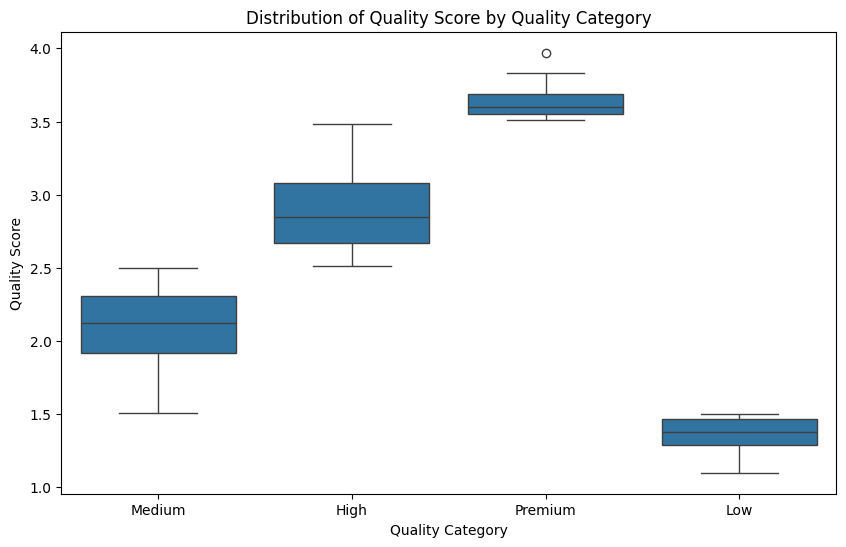

In [12]:
quality_summary = df_grape.groupby('quality_category')['quality_score'].describe()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_grape, x='quality_category', y='quality_score')
plt.title('Distribution of Quality Score by Quality Category')
plt.xlabel('Quality Category')
plt.ylabel('Quality Score')
plt.show()

In [13]:
quality_summary

,count,mean,std,min,25%,50%,75%,max
quality_category,,,,,,,,
High,468.0,2.888910,0.252297,2.51,2.6700,2.850,3.0825,3.48
Low,26.0,1.362692,0.115847,1.10,1.2925,1.375,1.4675,1.50
Medium,477.0,2.100147,0.258216,1.51,1.9200,2.120,2.3100,2.50
Premium,29.0,3.625862,0.105679,3.51,3.5500,3.600,3.6900,3.97


Score Ranges:

    Low: 1.10 to 1.50
    Medium: 1.51 to 2.50
    High: 2.51 to 3.48
    Premium: 3.51 to 4.00 (max here is 3.97)

### Addressing Class balance issue

#### Explanation here

#### Step 1: Define score ranges (clusters) based on quality_score

In [14]:
grape_resample=df_grape
grape_resample

,variety,region,quality_score,quality_category,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,sun_exposure_hours,soil_moisture_percent,rainfall_mm,day_of_year,month
sample_id,,,,,,,,,,,,,
1,Riesling,Barossa Valley,2.11,Medium,13.70,3.17,251.81,18.58,8.4,55.9,223.3,247,9
2,Pinot Noir,Loire Valley,2.83,High,20.84,3.15,289.00,22.08,8.8,36.9,312.1,259,9
3,Sauvignon Blanc,Napa Valley,3.52,Premium,27.46,4.07,125.14,21.40,11.1,64.9,698.7,237,8
4,Riesling,Napa Valley,2.28,Medium,24.64,3.15,237.46,12.31,8.0,54.5,660.1,256,9
5,Merlot,Napa Valley,2.90,High,26.13,3.18,221.52,12.24,11.2,36.3,410.4,223,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Sauvignon Blanc,Napa Valley,3.14,High,23.14,4.01,182.63,23.46,10.1,53.2,363.9,252,9
997,Cabernet Sauvignon,Sonoma,2.65,High,29.13,3.02,150.32,11.79,9.0,56.7,325.7,231,8
998,Pinot Noir,Napa Valley,2.11,Medium,11.38,3.23,168.37,14.92,10.6,66.5,473.2,240,8


In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for column in ['variety', 'region']:
    label_encoders[column] = LabelEncoder()
    grape_resample[column] = label_encoders[column].fit_transform(grape_resample[column])

In [16]:
def generate_synthetic_samples(cluster_data, n_samples=100):
    n_neighbors = min(5, len(cluster_data))
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(cluster_data)

    synthetic_samples = []
    for _ in range(n_samples):
        idx = np.random.choice(range(len(cluster_data)))
        sample = cluster_data[idx]
        
        neighbors = neigh.kneighbors([sample], return_distance=False)[0]
        neighbor_sample = cluster_data[np.random.choice(neighbors)]
        
        alpha = np.random.rand()
        synthetic_sample = sample + alpha * (neighbor_sample - sample)
        
        synthetic_samples.append(synthetic_sample)
    
    return np.array(synthetic_samples)

In [17]:
synthetic_data = []
for label in ['Low', 'Premium']:
    cluster_data = grape_resample[grape_resample['quality_category'] == label].drop(columns=['quality_category']).values
    #We drop the label column because not encoded : we will recreate it later
    if len(cluster_data) > 1:
        synthetic_samples = generate_synthetic_samples(cluster_data, n_samples=100)
        synthetic_data.append(synthetic_samples)

In [18]:
synthetic_data_combined = np.vstack(synthetic_data)

numeric_columns = grape_resample.drop(columns=['quality_category']).columns
print(numeric_columns)

synthetic_df = pd.DataFrame(synthetic_data_combined, columns=numeric_columns)
synthetic_df.head()

Index(['variety', 'region', 'quality_score', 'sugar_content_brix',
       'acidity_ph', 'cluster_weight_g', 'berry_size_mm', 'sun_exposure_hours',
       'soil_moisture_percent', 'rainfall_mm', 'day_of_year', 'month'],
      dtype='object')


,variety,region,quality_score,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,sun_exposure_hours,soil_moisture_percent,rainfall_mm,day_of_year,month
0,1.000000,3.989380,1.287405,14.195706,3.651699,140.450699,10.818786,6.418513,45.879652,233.002294,240.672217,8.402124
1,5.000000,1.000000,1.350000,11.520000,4.050000,235.040000,10.240000,8.300000,34.100000,643.100000,273.000000,9.000000
2,3.235999,1.788799,1.435280,12.258640,3.876648,144.228053,13.909953,6.778880,58.529841,503.332015,238.242408,8.552800
3,2.312572,2.374856,1.361880,13.200127,3.374418,309.230958,11.058720,7.068743,46.662745,244.049366,225.688581,8.000000
4,3.904572,4.547714,1.429046,14.455726,3.717276,115.570360,11.304165,7.038867,32.010238,235.863721,248.300194,8.484095


### Add the labels back

In [19]:
bins = [1.0, 1.5, 2.5, 3.5, 4.0]
labels = ['Low', 'Medium', 'High', 'Premium']
grape_resample['data_type'] = 'Original'
synthetic_df['data_type'] = 'Synthetic'

In [20]:
synthetic_df['quality_category'] = pd.cut(synthetic_df['quality_score'], bins=bins, labels=labels, include_lowest=True)

balanced_grape_data = pd.concat([grape_resample, synthetic_df], ignore_index=True)

balanced_grape_data.head()

,variety,region,quality_score,quality_category,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,sun_exposure_hours,soil_moisture_percent,rainfall_mm,day_of_year,month,data_type
0,4.0,0.0,2.11,Medium,13.70,3.17,251.81,18.58,8.4,55.9,223.3,247.0,9.0,Original
1,3.0,2.0,2.83,High,20.84,3.15,289.00,22.08,8.8,36.9,312.1,259.0,9.0,Original
2,5.0,4.0,3.52,Premium,27.46,4.07,125.14,21.40,11.1,64.9,698.7,237.0,8.0,Original
3,4.0,4.0,2.28,Medium,24.64,3.15,237.46,12.31,8.0,54.5,660.1,256.0,9.0,Original
4,2.0,4.0,2.90,High,26.13,3.18,221.52,12.24,11.2,36.3,410.4,223.0,8.0,Original


## Resample analysis

In [44]:
numeric_data = balanced_grape_data.select_dtypes(include=[np.number]).drop(columns=['quality_score'], errors='ignore')

print("Final numeric columns for analysis reduction:", numeric_data.columns)
numeric_data.dtypes

Final numeric columns for analysis reduction: Index(['variety', 'region', 'sugar_content_brix', 'acidity_ph',
       'cluster_weight_g', 'berry_size_mm', 'sun_exposure_hours',
       'soil_moisture_percent', 'rainfall_mm', 'day_of_year', 'month'],
      dtype='object')


variety                  float64
region                   float64
sugar_content_brix       float64
acidity_ph               float64
cluster_weight_g         float64
berry_size_mm            float64
sun_exposure_hours       float64
soil_moisture_percent    float64
rainfall_mm              float64
day_of_year              float64
month                    float64
dtype: object

# Apply PCA for dimensionality reduction

In [34]:
pca = PCA(n_components=2)

In [35]:
pca_result = pca.fit_transform(numeric_data.values)

In [36]:
pca_df = pd.DataFrame({
    'pca_dim1': pca_result[:, 0],
    'pca_dim2': pca_result[:, 1],
    'data_type': balanced_grape_data['data_type'].values,
    'quality_category': balanced_grape_data['quality_category'].values
})

In [37]:
pca_df.head()

,pca_dim1,pca_dim2,data_type,quality_category
0,-262.782326,51.885198,Original,Medium
1,-174.773978,90.539206,Original,High
2,214.859363,-66.272071,Original,Premium
3,174.196882,45.232817,Original,Medium
4,-75.277036,25.015617,Original,High


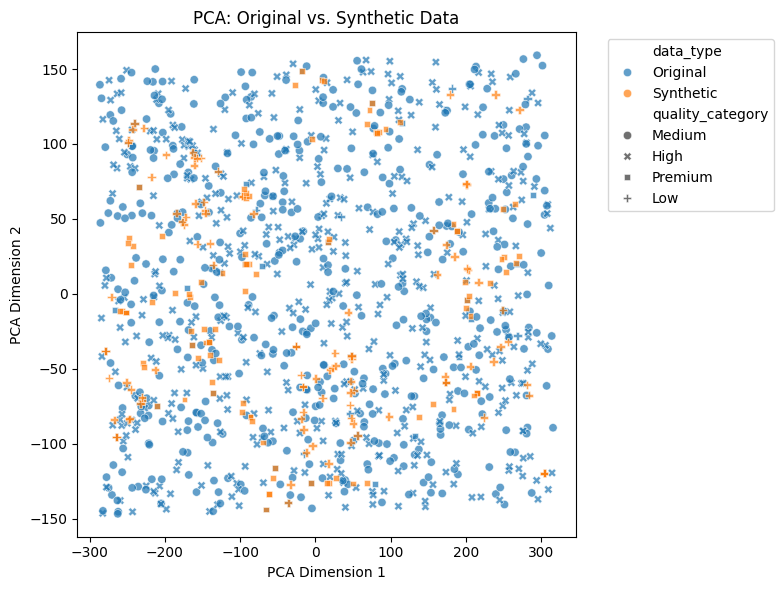

In [38]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pca_dim1', y='pca_dim2',
    hue='data_type', style='quality_category', 
    data=pca_df, alpha=0.7
)
plt.title("PCA: Original vs. Synthetic Data")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

 From this visualization, we can observe the distribution and overlap between the original and synthetic data points across the PCA dimensions.

 - The synthetic data points (in orange) are generally well-distributed across the same space as the original data points (in blue), indicating that the synthetic samples are similar in distribution to the original data. This suggests that the synthetic data generation process has been successful in mimicking the distribution of the original dataset.

 - Different markers represent the quality_category labels (Low, Medium, High, Premium). While there is some separation, categories appear to be relatively mixed, suggesting that quality_category alone may not create distinct clusters in this feature space. This could imply that other factors influence the quality, and PCA may not fully capture the variation for each category in just two dimensions.

 As we want a more nuanced view of clusters, especially as 'quality_category' might have non-linear relationships, t-SNE might reveal additional clustering patterns.

# t-SNE

In [ ]:
# TO help issue wth CPU
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

In [41]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(numeric_data.values)

In [42]:
tsne_df = pd.DataFrame({
    'tsne_dim1': tsne_result[:, 0],
    'tsne_dim2': tsne_result[:, 1],
    'data_type': balanced_grape_data['data_type'].values,
    'quality_category': balanced_grape_data['quality_category'].values
})
tsne_df.head()

,tsne_dim1,tsne_dim2,data_type,quality_category
0,-43.557610,9.766824,Original,Medium
1,-32.248680,20.511534,Original,High
2,35.899929,-11.166104,Original,Premium
3,30.488861,6.656024,Original,Medium
4,-12.456690,5.728007,Original,High


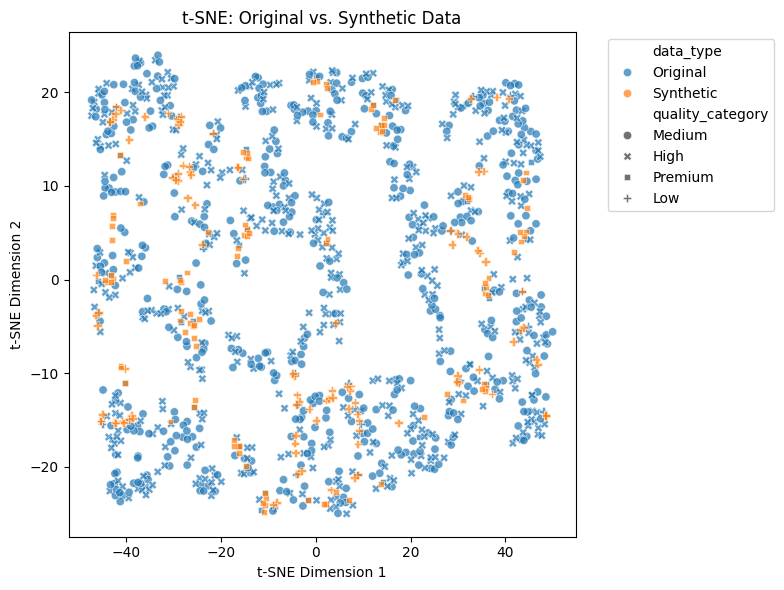

In [43]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='tsne_dim1', y='tsne_dim2',
    hue='data_type', style='quality_category',
    data=tsne_df, alpha=0.7
)
plt.title("t-SNE: Original vs. Synthetic Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The t-SNE plot shows more defined clustering patterns compared to PCA. t-SNE is often better at capturing non-linear relationships, so we see some distinct groupings, although there's still some overlap between categories. This indicates that certain features differentiate quality_category groups better in a non-linear space.

The synthetic data (orange) is generally well-distributed among the original data clusters (blue). This suggests that the synthetic data generation process has managed to create samples that fit well with the structure of the original data, even in a non-linear reduced space.

There are regions with high density for specific categories, like Medium and High, while Low and Premium are more sparsely represented, consistent with the original data distribution.

Since t-SNE shows some separation, it could be valuable to explore models that capture non-linear relationships (e.g., decision trees, random forests, or neural networks) to classify quality_category

# Export data

In [45]:
balanced_grape_data.head()

,variety,region,quality_score,quality_category,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,sun_exposure_hours,soil_moisture_percent,rainfall_mm,day_of_year,month,data_type
0,4.0,0.0,2.11,Medium,13.70,3.17,251.81,18.58,8.4,55.9,223.3,247.0,9.0,Original
1,3.0,2.0,2.83,High,20.84,3.15,289.00,22.08,8.8,36.9,312.1,259.0,9.0,Original
2,5.0,4.0,3.52,Premium,27.46,4.07,125.14,21.40,11.1,64.9,698.7,237.0,8.0,Original
3,4.0,4.0,2.28,Medium,24.64,3.15,237.46,12.31,8.0,54.5,660.1,256.0,9.0,Original
4,2.0,4.0,2.90,High,26.13,3.18,221.52,12.24,11.2,36.3,410.4,223.0,8.0,Original


### Encode categories

In [63]:
quality_mapping = {'Low': 1, 'Medium': 2, 'High': 3, 'Premium': 4}
balanced_grape_data['quality_category'] = balanced_grape_data['quality_category'].map(quality_mapping)

In [64]:
df_data_type=balanced_grape_data['data_type']
df_split=balanced_grape_data.drop(columns=['data_type'])
df_train, df_validation = train_test_split(df_split, test_size=0.2, random_state=42)
df_train = df_train.drop(columns=['quality_score'])
df_validation_score = df_validation['quality_score']
df_validation = df_validation.drop(columns=['quality_score'])

In [65]:
df_validation.head()

,variety,region,quality_category,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,sun_exposure_hours,soil_moisture_percent,rainfall_mm,day_of_year,month
1178,4.88715,4.0,4,27.524889,4.049687,123.619912,21.466581,11.094358,64.612233,694.016729,237.507825,8.056425
865,0.00000,6.0,3,28.750000,3.610000,156.470000,19.530000,8.700000,42.100000,783.900000,218.000000,8.000000
101,1.00000,6.0,3,29.380000,3.550000,274.520000,16.400000,9.500000,58.900000,320.800000,229.000000,8.000000
439,2.00000,1.0,3,23.470000,3.020000,328.740000,13.610000,11.100000,51.200000,276.400000,270.000000,9.000000
58,2.00000,0.0,3,19.600000,3.710000,72.680000,23.350000,9.300000,63.900000,739.800000,231.000000,8.000000


In [66]:
print(df_data_type.head())
print(df_validation_score.head())

0    Original
1    Original
2    Original
3    Original
4    Original
Name: data_type, dtype: object
1178    3.530156
865     3.180000
101     3.160000
439     2.780000
58      2.870000
Name: quality_score, dtype: float64


### Export Train and Test

In [67]:
export_path='../../data'
df_data_type.to_csv(f'{export_path}/df_data_type.csv', index=True) 
df_train.to_csv(f'{export_path}/df_train.csv', index=True)
df_validation.to_csv(f'{export_path}/df_validation.csv', index=True)
df_validation_score.to_csv(f'{export_path}/df_validation_score.csv', index=True)